Домашнее задание по NLP # 2 [100 баллов]
=======
Составление словарей для классификации по тональности

При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: “теплое пиво” – это плохо, а “теплый свитер” – это хорошо.

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).

Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

Разбейте всю коллекцию отзывов на предложения. 

Лемматизируйте все слова.

Обучите по коллекции предложений word2vec
Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
1. тест на определение ближайших слов
2. тест на аналогии (мужчина – король : женщина – королева)
3. тест на определение лишнего слова.

Постройте несколько визуализаций:
TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

In [1]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
tqdm.pandas()
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/andreysemeshin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  if sys.path[0] == '':
/Users/andreysemeshin/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

from nltk import FreqDist

from sklearn.manifold import TSNE

from IPython.display import Image

In [3]:
responses = []
with bz2.BZ2File('/Users/andreysemeshin/Downloads/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

In [4]:
df = pd.DataFrame(responses)

In [5]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [6]:
# без рейтинга удалим
df.dropna(subset=['rating_grade'], inplace = True)

In [7]:
# Возьмем только полностью пложительные и отрицаетльные отзывы
df = df.loc[(df['rating_grade'] == 1.0) | (df['rating_grade'] == 5.0)]

In [8]:
df.tail()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
153493,None,False,Два конфликта с банком.,0,лицензия № 2771,Sam,Юниаструм Банк,2005-05-18 01:25:00,Оформил в банке кредитную карту в январе 2004 ...,1.0
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0
153498,None,False,Быстро и удобно,0,лицензия № 1326,Денис,Альфа-Банк,2005-04-13 17:43:00,"Если коротко, то мне нравится. Кридит получать...",5.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62100 entries, 19 to 153498
Data columns (total 10 columns):
city                  50366 non-null object
rating_not_checked    62100 non-null bool
title                 62100 non-null object
num_comments          62100 non-null int64
bank_license          62100 non-null object
author                62092 non-null object
bank_name             62100 non-null object
datetime              62100 non-null object
text                  62100 non-null object
rating_grade          62100 non-null float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 4.8+ MB


Лемматизируем:

In [10]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""
    
from nltk.corpus import stopwords
 #print(stopwords.words('russian'))
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return 
    
    
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "
   

mystoplemmas = stopwords.words('russian') + ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [11]:
df['text_tokinized'] =  df.text.str.lower().apply(words_only)

df['text_tokinized_without_stop_worlds'] =  df.text_tokinized.str.lower().apply(remove_stopwords)

with Pool(4) as p:
    df['lemma'] = p.map(lemmatize, df['text_tokinized_without_stop_worlds'])
    
with Pool(4) as p:
    df['lemma'] = p.map(remove_stoplemmas,df.lemma)

In [13]:
df.tail(5)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_without_stop_worlds,lemma
153493,None,False,Два конфликта с банком.,0,лицензия № 2771,Sam,Юниаструм Банк,2005-05-18 01:25:00,Оформил в банке кредитную карту в январе 2004 ...,1.0,оформил в банке кредитную карту в январе г пер...,оформил банке кредитную карту январе г первый ...,оформлять банк кредитный карта январь г первый...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0,слишком большой банк не всегда учитывает нашу ...,слишком большой банк учитывает нашу специфику ...,слишком большой банк учитывать специфика проду...
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0,уважаемое руководство банка овк я проживаю в г...,уважаемое руководство банка овк проживаю г ива...,уважать руководство банк овк проживать г ивано...
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0,пробовала оформить товар в кредит в альфа банк...,пробовала оформить товар кредит альфа банке ко...,пробовать оформлять товар кредит альфа банк ко...
153498,None,False,Быстро и удобно,0,лицензия № 1326,Денис,Альфа-Банк,2005-04-13 17:43:00,"Если коротко, то мне нравится. Кридит получать...",5.0,если коротко то мне нравится кридит получать м...,коротко нравится кридит получать милое дело ан...,короче нравиться кридит получать милый дело ан...


In [14]:
lemma_text = df['lemma']

In [15]:
lemma_text.head()

19    открывать вклад счет плюс зарплатный карта руб...
33    добрый время вчера поступать смс уведомление б...
76    г около час приходить указанный офис намерение...
85    оплата коммунальный платеж пользоваться пласти...
94    апрель год приходить отделение сбербанк г чапа...
Name: lemma, dtype: object

In [16]:
texts = [str(text).split() for text in lemma_text.values]

In [17]:
%%time
model = Word2Vec(texts, size=100, window=5, min_count=5, workers=4)
model.save("word2vec_model")

CPU times: user 1min 21s, sys: 495 ms, total: 1min 22s
Wall time: 24.7 s


In [18]:
model = Word2Vec.load("word2vec_model")

1. тест на определение ближайших слов

In [19]:
model.wv.most_similar("банк")

[('банка', 0.7980429530143738),
 ('сбербанк', 0.5000126361846924),
 ('ситибанк', 0.47409436106681824),
 ('росбанк', 0.45277178287506104),
 ('мкб', 0.4490301012992859),
 ('компания', 0.43719884753227234),
 ('сбер', 0.4324929118156433),
 ('хотя', 0.4260159730911255),
 ('ранее', 0.4110574722290039),
 ('лично', 0.39808958768844604)]

In [20]:
model.wv.most_similar("спасибо")

[('респект', 0.7069031000137329),
 ('благодарить', 0.6222103238105774),
 ('благодарность', 0.6150090098381042),
 ('благодарный', 0.5758928656578064),
 ('молодец', 0.5714294910430908),
 ('удача', 0.5604597926139832),
 ('пожелать', 0.541420042514801),
 ('поблагодарить', 0.5249455571174622),
 ('уважение', 0.499664843082428),
 ('благодаря', 0.49886399507522583)]

In [21]:
model.wv.most_similar("недовольство")

[('негодование', 0.7927039861679077),
 ('неудовольствие', 0.730400025844574),
 ('раздражение', 0.704993724822998),
 ('фи', 0.6980540752410889),
 ('восхищение', 0.6723512411117554),
 ('неприязнь', 0.6591964960098267),
 ('сочувствие', 0.6530567407608032),
 ('намек', 0.637047290802002),
 ('возмущение', 0.6298771500587463),
 ('выказывать', 0.6296874284744263)]

In [22]:
model.wv.most_similar("доллар")

[('евро', 0.9122540950775146),
 ('долл', 0.8372254371643066),
 ('валюта', 0.7881002426147461),
 ('крона', 0.7422442436218262),
 ('бакс', 0.74185711145401),
 ('сконвертировать', 0.7410284876823425),
 ('фунт', 0.7369272708892822),
 ('сша', 0.7301082611083984),
 ('дол', 0.6735202670097351),
 ('долларовый', 0.6705640554428101)]

2. тест на аналогии (мужчина – король : женщина – королева)

In [23]:
model.wv.most_similar(positive=["евро", 'доллар'], negative=["сбербанк"])

[('долл', 0.7514623999595642),
 ('крона', 0.7406182289123535),
 ('сконвертировать', 0.7312496900558472),
 ('фунт', 0.722041130065918),
 ('валюта', 0.7177473306655884),
 ('бакс', 0.6890290379524231),
 ('шведский', 0.6713396310806274),
 ('сша', 0.6472938060760498),
 ('австралийский', 0.640658438205719),
 ('юань', 0.6378275752067566)]

3. тест на определение лишнего слова.

In [24]:
model.wv.doesnt_match("евро доллар рубль машина".split())

/Users/andreysemeshin/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'машина'

In [25]:
model.wv.doesnt_match("кредит депозит торт карта счет".split())

'торт'

In [26]:
model.wv.doesnt_match("сбербанк мтс бинбанк компьютер втб альфа райффайзенбанк".split())

'компьютер'

Визуализации
======

In [27]:
top_words = []
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(200):
    top_words.append(i[0])
print(top_words)

['банк', 'карта', 'деньги', 'день', 'отделение', 'кредит', 'сотрудник', 'клиент', 'счет', 'сказать', 'получать', 'заявление', 'сумма', 'год', 'вопрос', 'время', 'офис', 'приходить', 'ответ', 'кредитный', 'вклад', 'звонить', 'очень', 'телефон', 'позвонить', 'платеж', 'договор', 'банкомат', 'данный', 'работать', 'месяц', 'написать', 'г', 'решать', 'проблема', 'документ', 'обращаться', 'сбербанк', 'работа', 'ваш', 'номер', 'отвечать', 'говорить', 'рубль', 'хотеть', 'средство', 'ситуация', 'человек', 'звонок', 'оформлять', 'минута', 'сообщать', 'давать', 'сделать', 'просто', 'очередь', 'почему', 'обслуживание', 'срок', 'заявка', 'знать', 'информация', 'девушка', 'должный', 'услуга', 'операция', 'первый', 'банка', 'ждать', 'претензия', 'неделя', 'сегодня', 'принимать', 'открывать', 'новый', 'смс', 'выдавать', 'час', 'сайт', 'закрывать', 'процент', 'оператор', 'никакой', 'предлагать', 'руб', 'проходить', 'оказываться', 'снимать', 'интернет', 'становиться', 'самый', 'нужно', 'объяснять', 'пис

In [28]:
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(model.wv[top_words])

ТОП слова
=====

In [29]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan, wheel_zoom, reset, save",
           toolbar_location="above",
           title="word2vec T-SNE топ слова")
source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)
labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)
show(p)

Loading BokehJS ...

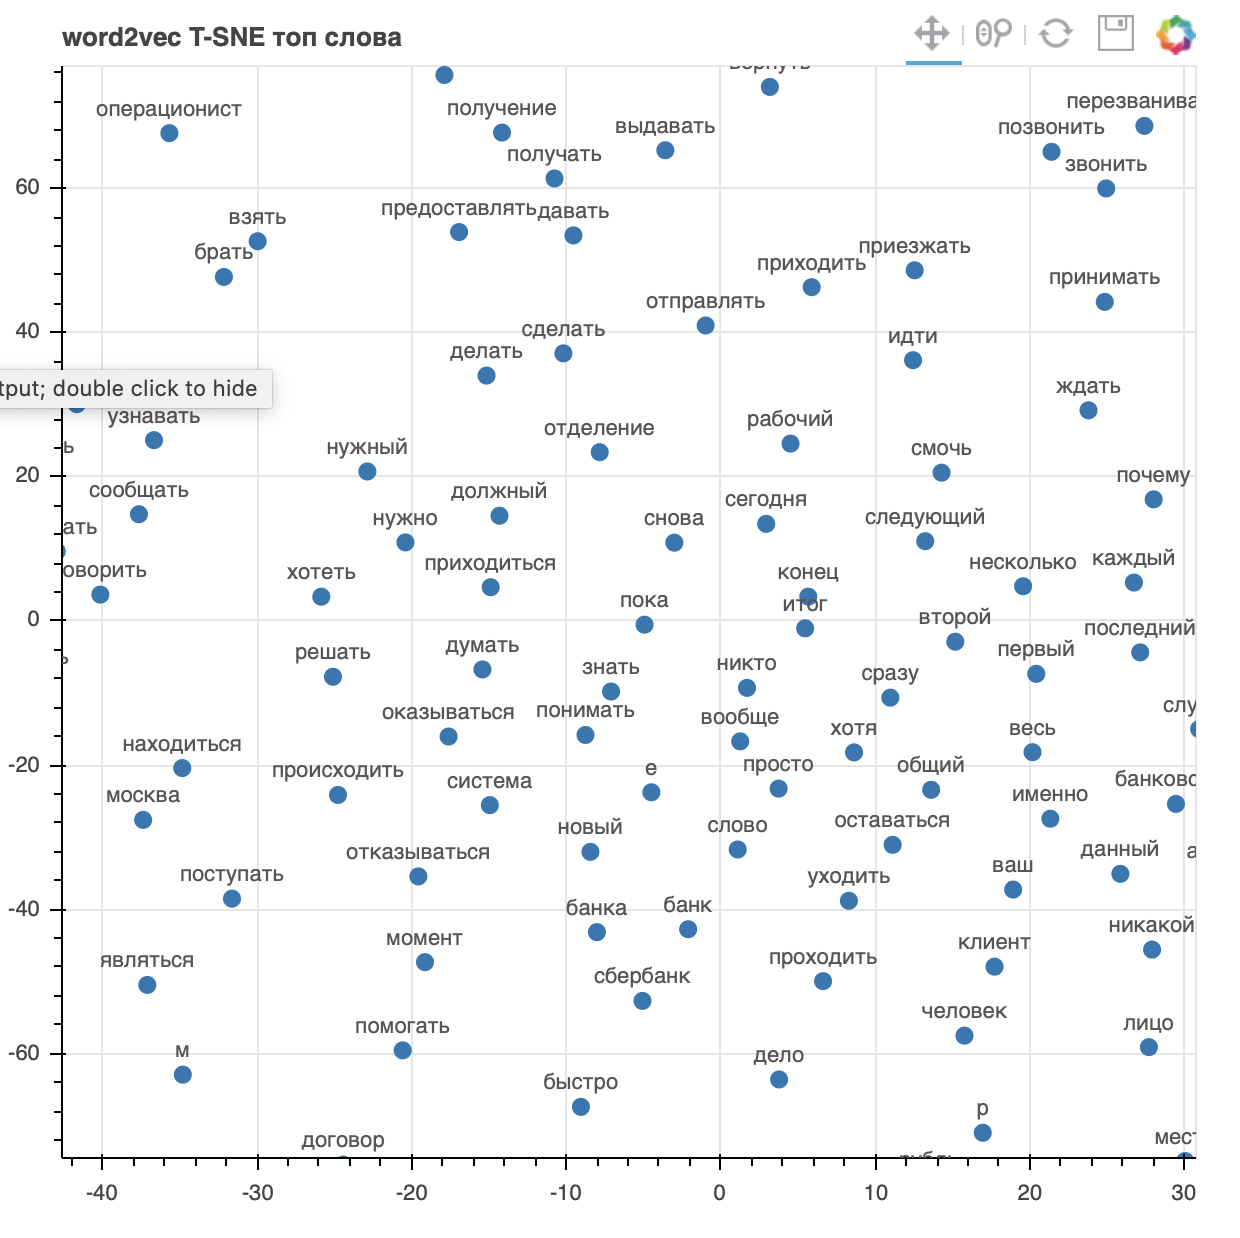

In [35]:
# покажем что получилось
img = Image(filename='img/screen_1.png')
display(img)

Новое пространство: Плохо – хорошо,  медленно – быстро
=====

In [31]:
vector_good_bad = model.wv['отлично'] - model.wv['плохо']
vector_fast_slow = model.wv['быстро'] - model.wv['медленно']

In [32]:
banks = ['сбербанк', 'втб', 'райффайзенбанк', 'альфа', 'стандарт', 'ситибанк', 'мтс', 'мкб', 'хоум', 'связной', 'отп', 'авангард']
df = pd.DataFrame.from_dict({'bank': banks})
df['vector'] = df.apply(lambda row: model.wv[row['bank']], axis=1)
df['bad_good'] = df.apply(lambda row: np.dot(vector_good_bad, row['vector']), axis=1)
df['slow_fast'] = df.apply(lambda row: np.dot(vector_fast_slow, row['vector']), axis=1)

In [33]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Новое пространство: Плохо – хорошо, медленно – быстро")
source = ColumnDataSource(data=dict(x1=df.bad_good,
                                    x2=df.slow_fast,
                                    names=df.bank))
p.scatter(x="x1", y="x2", size=4, source=source)
labels = LabelSet(x="x1", y="x2", text="names", y_offset=3,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)
p.xaxis.axis_label = 'Плохо --> Хорошо'
p.yaxis.axis_label = 'Медленно --> Быстро'
show(p)

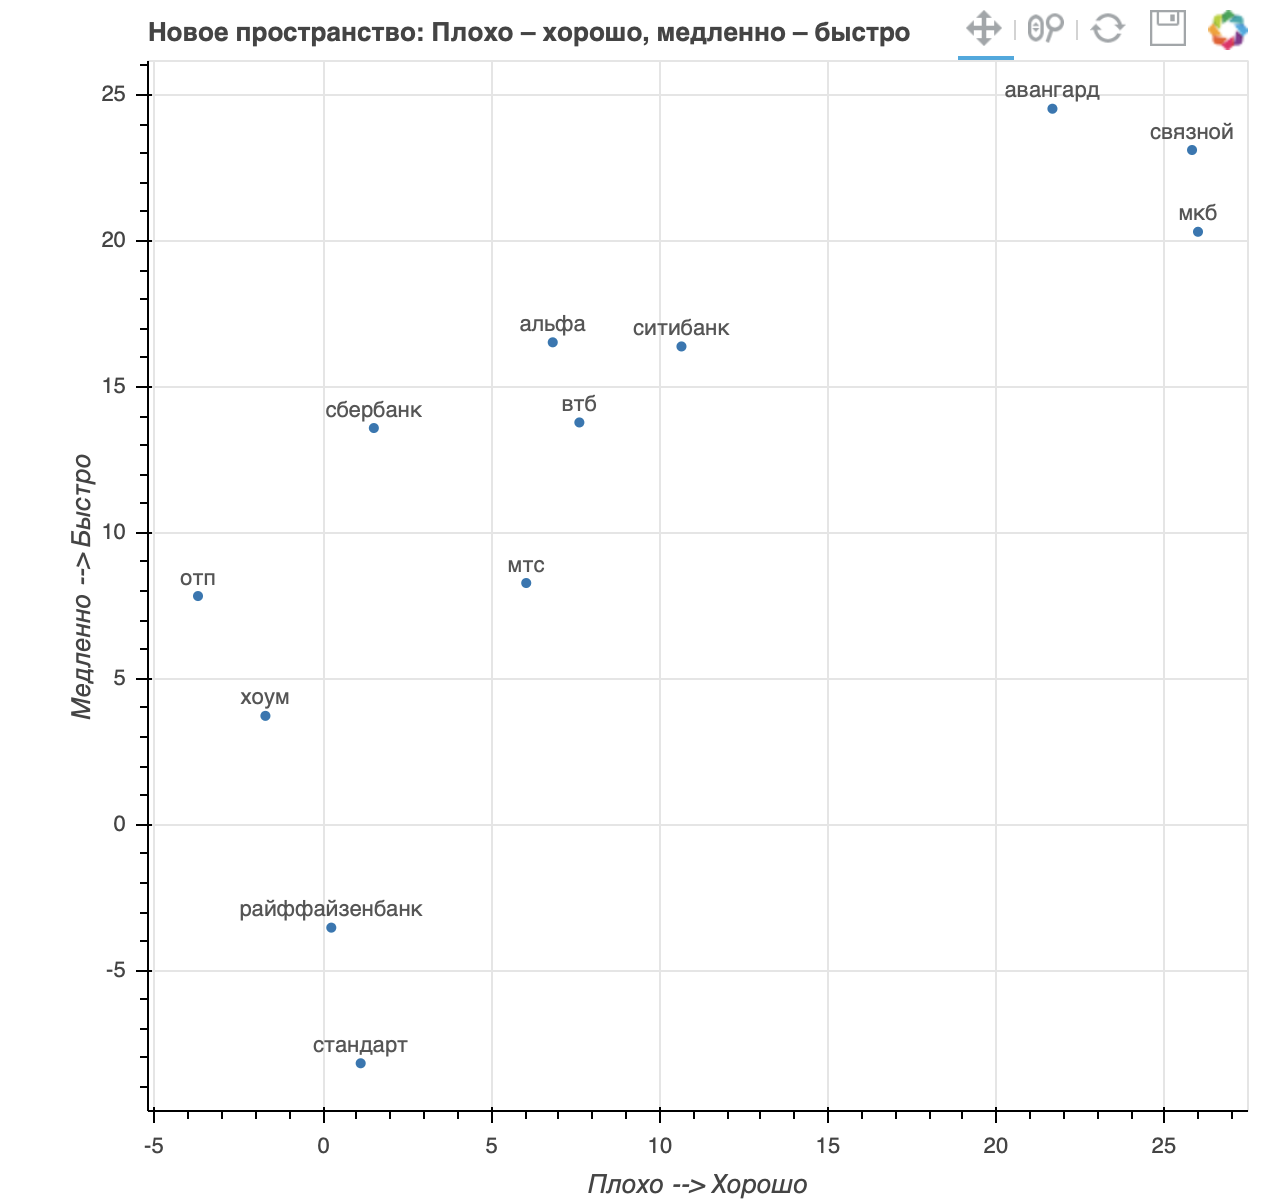

In [36]:
# покажем что получилось
img = Image(filename='img/screen_2.png')
display(img)

Банки Авангард, связной, мкб показали лучший результат :)